# Dictyostelium Aggregation Prediction

## Abstract

This project evaluates the performance of three deep learning architectures—3D CNN Encoder-Decoder, Stacked U-Net, and 3D Attention U-Net—in predicting the final aggregation center of Dictyostelium discoideum using time-subsampled imaging data from Janelia HHMI. Models were assessed based on center prediction error ($\mu$ m), spatial AUROC, and robustness under reduced resolution. Results show that the 3D Attention U-Net achieves the best overall accuracy but is highly sensitive to resolution degradation; the simple Encoder-Decoder is the most robust to resolution changes but performs comparatively poorly; and the Stacked U-Net offers intermediate accuracy while achieving the highest spatial AUROC.

In [ ]:
%pip install seaborn

In [29]:
import os
import zarr
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import scipy.ndimage as nd
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import seaborn as sns
import random
from tqdm import tqdm
import copy

In [2]:
def set_seed(seed: int = 123):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(82)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {DEVICE}")

data_path = "data/subsampled"
folder_list = ['mixin44_sub', 'mixin57_sub', 'mixin64_sub']

MICRONS_PER_PIXEL = {
    'mixin44_sub': 2.41, 
    'mixin57_sub': 2.41, 
    'mixin64_sub': 1.28
}

Running on: cuda


# Data Exploration

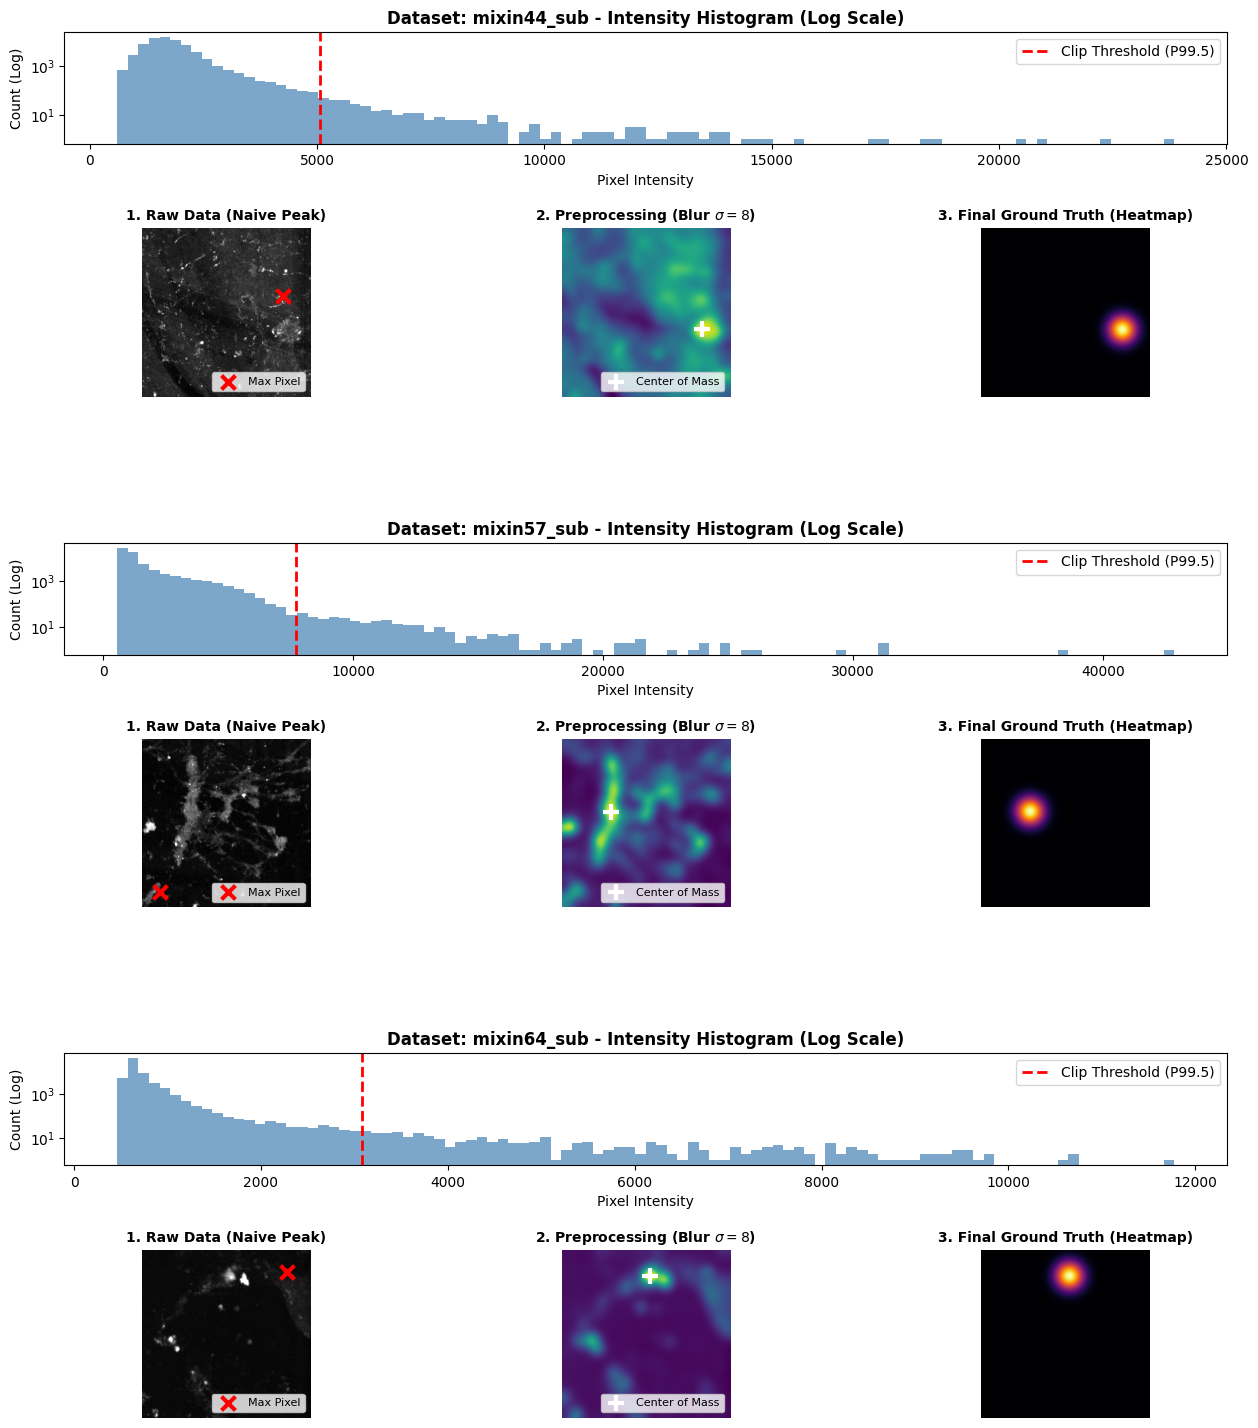

In [33]:
fig = plt.figure(figsize=(15, 18))
outer_grid = gridspec.GridSpec(3, 1, figure=fig, hspace=0.4)

for i, folder in enumerate(folder_list):
    path = os.path.join(data_path, folder)
    z = zarr.open(path, mode='r')
    raw_volume = np.max(z[:], axis=2)[:, 0, :, :] 
    # sample_frame = raw_volume[len(raw_volume)//2]
    sample_frame = raw_volume[-1]
    
    inner_grid = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=outer_grid[i], 
                                                  height_ratios=[1, 1.5], hspace=0.6, wspace=0.3)
    
    ax_hist = fig.add_subplot(inner_grid[0, :])
    
    flat_pixels = sample_frame.flatten()
    p1 = np.percentile(flat_pixels, 1)
    p99 = np.percentile(flat_pixels, 99.5)
    
    ax_hist.hist(flat_pixels, bins=100, color='steelblue', alpha=0.7, log=True)
    ax_hist.axvline(p99, color='red', linestyle='--', linewidth=2, label=f'Clip Threshold (P99.5)')
    ax_hist.set_title(f"Dataset: {folder} - Intensity Histogram (Log Scale)", fontweight='bold')
    ax_hist.set_xlabel("Pixel Intensity")
    ax_hist.set_ylabel("Count (Log)")
    ax_hist.legend()

    clipped_img = np.clip(sample_frame, p1, p99)
    norm_img = (clipped_img - p1) / (p99 - p1 + 1e-9)
    
    raw_max_idx = np.argmax(sample_frame)
    raw_y, raw_x = np.unravel_index(raw_max_idx, sample_frame.shape)
    
    sigma_blur = 8
    g_blur = nd.gaussian_filter(norm_img, sigma=sigma_blur)
    thresh = np.percentile(g_blur, 99.9)
    blur_y, blur_x = nd.center_of_mass(g_blur > thresh)
    
    y_grid, x_grid = np.ogrid[:256, :256]
    dist_sq = (x_grid - blur_x)**2 + (y_grid - blur_y)**2
    target_hm = np.exp(-dist_sq / (2.0 * 15.0**2))
    
    ax_raw = fig.add_subplot(inner_grid[1, 0])
    ax_raw.imshow(sample_frame, cmap='gray', vmax=p99*1.5)
    ax_raw.scatter([raw_x], [raw_y], c='red', marker='x', s=100, linewidth=3, label='Max Pixel')
    ax_raw.set_title("1. Raw Data (Naive Peak)", fontsize=10, fontweight='bold')
    ax_raw.legend(loc='lower right', fontsize=8)
    ax_raw.axis('off')

    ax_blur = fig.add_subplot(inner_grid[1, 1])
    ax_blur.imshow(g_blur, cmap='viridis')
    ax_blur.scatter([blur_x], [blur_y], c='white', marker='+', s=120, linewidth=3, label='Center of Mass')
    ax_blur.set_title(f"2. Preprocessing (Blur $\sigma={sigma_blur}$)", fontsize=10, fontweight='bold')
    ax_blur.legend(loc='lower right', fontsize=8)
    ax_blur.axis('off')

    ax_target = fig.add_subplot(inner_grid[1, 2])
    ax_target.imshow(target_hm, cmap='inferno')
    ax_target.set_title("3. Final Ground Truth (Heatmap)", fontsize=10, fontweight='bold')
    ax_target.axis('off')

plt.show()

The intermediate exploratory steps are omitted for brevity. The figure above provides key visualizations highlighting the most relevant characteristics of the datasets.

The raw videos contain a z-dimension, which is less relevant for characterizing the aggregation behavior of Dictyostelium. Therefore, the z-axis was collapsed using a maximum-intensity projection, preserving the brightest structures on x,y dimensions.

Histogram analysis across the three datasets reveals the presence of extreme intensity outliers, with peak values exceeding the 99.5th percentile by a factor of 3–6. Further visual inspection shows that these bright spots are typically unrelated to the visible aggregation center and may introduce undesired bias during model training.

Since the datasets do not include pre-annotated aggregation frames or center locations, it was necessary to define ground truth annotations. For the purposes of this project, the final frame of each video was treated as the aggregation frame, as it most clearly exhibits the completed aggregation pattern. A Gaussian blur mask ($\sigma = 8$) was applied to this frame to suppress outliers and enable reliable automatic computation of the center of mass.

# Data processing

In [3]:
class DictyHeatmapDataset(Dataset):
    def __init__(self, root_dir, folder, N, sigma, augment=False):
        self.N = N
        self.augment = augment
        path = os.path.join(root_dir, folder)
        self.folder_name = folder
        z = zarr.open(path, mode='r')
        raw = np.max(z[:], axis=2)[:,0,:,:]
        p1 = np.percentile(raw, 1)
        p99 = np.percentile(raw, 99.5)
        raw = np.clip(raw, p1, p99)
        self.data = ((raw - p1) / (p99 - p1 + 1e-9)).astype(np.float32)
        g_blur = nd.gaussian_filter(self.data[-1], sigma=sigma)
        thresh = np.percentile(g_blur, 99.9)
        blur_y, blur_x = nd.center_of_mass(g_blur > thresh)
        self.target_x = blur_x
        self.target_y = blur_y
        self.total_steps = self.data.shape[0] - self.N
    def __len__(self):
        return self.total_steps
    def _apply_augmentation(self, x, tx, ty):
        img_size = x.shape[-1]
        if random.random() > 0.5:
            x = torch.flip(x, dims=[-1])
            tx = img_size - tx
        if random.random() > 0.5:
            x = torch.flip(x, dims=[-2])
            ty = img_size - ty
        k = random.randint(0, 3)
        if k > 0:
            x = torch.rot90(x, k, dims=[-2, -1])
            for _ in range(k):
                old_x = tx; tx = ty; ty = img_size - old_x 
        return x, tx, ty
    def __getitem__(self, i):
        frame = self.data[i: i+self.N]
        x = torch.from_numpy(frame).unsqueeze(0)
        tx, ty = self.target_x, self.target_y
        progress = i / max(self.total_steps, 1)
        if self.augment:
            x, tx, ty = self._apply_augmentation(x, tx, ty)
        return x, torch.tensor([tx, ty], dtype=torch.float32), progress, self.folder_name

class HeatmapGenerator(nn.Module):
    def __init__(self, size=(256, 256), sigma=15.0, device='cuda'):
        super().__init__()
        self.sigma = sigma
        H, W = size
        grid_y, grid_x = torch.meshgrid(
            torch.arange(H, dtype=torch.float32, device=device), 
            torch.arange(W, dtype=torch.float32, device=device), 
            indexing='ij'
        )
        self.register_buffer('grid_y', grid_y)
        self.register_buffer('grid_x', grid_x)     
    def forward(self, coords):
        tx = coords[:, 0].view(-1, 1, 1)
        ty = coords[:, 1].view(-1, 1, 1)
        dist_sq = (self.grid_x - tx)**2 + (self.grid_y - ty)**2
        heatmap = torch.exp(-dist_sq / (2.0 * self.sigma**2))
        return heatmap.unsqueeze(1)

The dataset class implements the preprocessing steps described in the data exploration section, along with several additional utility functions that help accelerate model training.

Because the entire dataset contains only three videos, there are only three corresponding final-frame ground truth labels. This limited amount of supervision is suboptimal and may bias the model toward learning a form of classification rather than true prediction. To mitigate this issue, the dataset class incorporates simple built-in data augmentation. At present, the available augmentations include flips along the x- and y-axes and rotations in 90-degree increments.

# Models

## Model 1

In [4]:
class SmallEncoderDecoder(nn.Module):
    def __init__(self, K=10):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=(K, 4, 4), stride=(1, 2, 2), padding=(0, 1, 1)),
            nn.BatchNorm3d(16), nn.ReLU(),
            nn.Conv3d(16, 32, kernel_size=(1, 4, 4), stride=(1, 2, 2), padding=(0, 1, 1)),
            nn.BatchNorm3d(32), nn.ReLU(),
            nn.Conv3d(32, 64, kernel_size=(1, 4, 4), stride=(1, 2, 2), padding=(0, 1, 1)),
            nn.BatchNorm3d(64), nn.ReLU()
        )
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 4, stride=2, padding=1), nn.Sigmoid()
        )
    def forward(self, x):
        z = self.enc(x).squeeze(2)
        return self.dec(z)

The first model serves as a baseline to assess the fundamental learnability of the task using direct spatiotemporal feature extraction. To this end, a lightweight 3D Convolutional Encoder–Decoder architecture was designed. The network takes as input a 3D tensor of shape $(B,1,T,H,W)$ and processes it through an encoder composed of three sequential blocks of 3D convolutions followed by batch normalization and ReLU activation. Strided convolutions progressively reduce the spatiotemporal resolution, enabling the model to capture high-level motion features while compressing the temporal dimension. The resulting bottleneck representation is then projected into 2D space, and the decoder reconstructs a spatial prediction map using transposed 2D convolutions to upsample the resolution back to $(H,W)$, producing a single-channel probability map. 

## Model 2

In [5]:
class CBR(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1), 
            nn.BatchNorm2d(out_c), 
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1), 
            nn.BatchNorm2d(out_c), 
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.block(x)

class SimpleUNet(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.enc1 = CBR(in_ch, 32); self.pool1 = nn.MaxPool2d(2)
        self.enc2 = CBR(32, 64); self.pool2 = nn.MaxPool2d(2)
        self.enc3 = CBR(64, 128); self.pool3 = nn.MaxPool2d(2)
        self.bottle = CBR(128, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2); self.dec3 = CBR(256, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2); self.dec2 = CBR(128, 64)
        self.up1 = nn.ConvTranspose2d(64, 32, 2, stride=2); self.dec1 = CBR(64, 32)
        self.final = nn.Conv2d(32, out_ch, 1)
        self.final.bias.data.fill_(-5.0)
    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        b = self.bottle(self.pool3(e3))
        d3 = self.dec3(torch.cat([self.up3(b), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return self.final(d1)

class StackedUNet(nn.Module):
    def __init__(self, N=10):
        super().__init__()
        self.unet1 = SimpleUNet(in_ch=N, out_ch=1)
        self.unet2 = SimpleUNet(in_ch=N+1, out_ch=1)
    def forward(self, x):
        B, C, N, H, W = x.shape
        x_2d = x.view(B, N, H, W)
        out1 = torch.sigmoid(self.unet1(x_2d))
        out2 = self.unet2(torch.cat([x_2d, out1], dim=1))
        return torch.sigmoid(out2)

To address potential occlusions and improve localization precision, a Stacked U-Net architecture was adopted. The model uses a computationally-less-expensive pseudo-3D representation in which the temporal dimension $T$ is collapsed into the channel axis. This reshaping produces an input of shape $(B,T,H,W)$, enabling the network to capture temporal correlations through standard 2D convolutions applied across channels. The architecture incorporates a two-stage cascade mechanism. In the first stage, a U-Net processes the input frames and produces a coarse heatmap prediction. The second stage refines this estimate by taking as input a concatenation of the original frames and the initial prediction, allowing the model to revisit the data conditioned on its earlier output and progressively correct errors such as false positives while sharpening the estimated center location. This stacked refinement strategy balances computational efficiency with high localization accuracy.

## Model 3

In [7]:
class ConvBlock3D(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_c, out_c, 3, padding=1), nn.BatchNorm3d(out_c), nn.ReLU(inplace=True),
            nn.Conv3d(out_c, out_c, 3, padding=1), nn.BatchNorm3d(out_c), nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.conv(x)

class AttentionBlock3D(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(nn.Conv3d(F_g, F_int, 1), nn.BatchNorm3d(F_int))
        self.W_x = nn.Sequential(nn.Conv3d(F_l, F_int, 1), nn.BatchNorm3d(F_int))
        self.psi = nn.Sequential(nn.Conv3d(F_int, 1, 1), nn.BatchNorm3d(1), nn.Sigmoid())
        self.relu = nn.ReLU(inplace=True)
    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.psi(self.relu(g1 + x1))
        return x * psi

class AttentionUNet3D(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = ConvBlock3D(1, 16); self.pool1 = nn.MaxPool3d(2)
        self.enc2 = ConvBlock3D(16, 32); self.pool2 = nn.MaxPool3d(2)
        self.enc3 = ConvBlock3D(32, 64); self.pool3 = nn.MaxPool3d(2)
        self.bottle = ConvBlock3D(64, 128)
        self.up3 = nn.ConvTranspose3d(128, 64, 2, stride=2); self.att3 = AttentionBlock3D(64, 64, 32); self.dec3 = ConvBlock3D(128, 64)
        self.up2 = nn.ConvTranspose3d(64, 32, 2, stride=2); self.att2 = AttentionBlock3D(32, 32, 16); self.dec2 = ConvBlock3D(64, 32)
        self.up1 = nn.ConvTranspose3d(32, 16, 2, stride=2); self.att1 = AttentionBlock3D(16, 16, 8); self.dec1 = ConvBlock3D(32, 16)
        self.final = nn.Conv3d(16, 1, 1)
        self.final.bias.data.fill_(-5.0)
    def _match(self, src, tgt):
        if src.shape[2:] != tgt.shape[2:]:
            src = F.interpolate(src, size=tgt.shape[2:], mode='trilinear', align_corners=False)
        return src
    def forward(self, x):
        e1 = self.enc1(x); p1 = self.pool1(e1)
        e2 = self.enc2(p1); p2 = self.pool2(e2)
        e3 = self.enc3(p2); p3 = self.pool3(e3)
        b = self.bottle(p3)
        d3_up = self._match(self.up3(b), e3)
        d3 = self.dec3(torch.cat([d3_up, self.att3(d3_up, e3)], dim=1))
        d2_up = self._match(self.up2(d3), e2)
        d2 = self.dec2(torch.cat([d2_up, self.att2(d2_up, e2)], dim=1))
        d1_up = self._match(self.up1(d2), e1)
        d1 = self.dec1(torch.cat([d1_up, self.att1(d1_up, e1)], dim=1))
        out_3d = self.final(d1)
        out_2d, _ = torch.max(out_3d, dim=2)
        return torch.sigmoid(out_2d)

To fully exploit the volumetric structure of the data and reduce background distractions, a 3D Attention U-Net architecture was implemented. Unlike the 2.5D approach, the network preserves the full temporal dimension $T$ throughout both the encoder and decoder by employing 3D convolutions and 3D transposed convolutions, allowing temporal continuity to be modeled explicitly rather than implicitly through channel stacking. A central component of this architecture is the use of Attention Gates within the skip connections. Standard U-Net skip paths simply concatenate low- and high-level features, but the Attention Gates instead use coarse, high-level context to generate a gating signal that selectively filters low-level features before fusion. In the context of microscopy videos, where the aggregation center typically occupies a small and faint region relative to a large noisy background, these gates help suppress irrelevant activations and emphasize salient regions associated with the true aggregation signal, improving robustness against artifacts.

# Evaluation and Visualization functions

In [12]:
def get_peak_coords(heatmap):
    B, C, H, W = heatmap.shape
    heatmap_flat = heatmap.view(B, -1)
    max_val, max_idx = torch.max(heatmap_flat, dim=1)
    pred_y = max_idx // W
    pred_x = max_idx % W
    coords = torch.stack([pred_x, pred_y], dim=1).float()
    return coords

def compute_auroc(pred_map, target_map):
    pred_np = pred_map.detach().cpu().numpy().flatten()
    target_np = target_map.detach().cpu().numpy().flatten()
    target_bin = (target_np > 0.5).astype(int)
    if len(np.unique(target_bin)) < 2:
        return 0.5 
    return roc_auc_score(target_bin, pred_np)

def compute_robustness(model, x, target_coords, original_error_px, heatmap_gen):
    x_down = F.interpolate(x, scale_factor=(1, 0.5, 0.5), mode='trilinear', align_corners=False)
    x_recovered = F.interpolate(x_down, size=x.shape[2:], mode='trilinear', align_corners=False)
    pred_rob = model(x_recovered)
    p_coords = get_peak_coords(pred_rob)
    delta = p_coords - target_coords
    rob_error_px = torch.norm(delta, p=2, dim=1).mean().item()
    if original_error_px < 1e-6: return 0.0
    relative_drop = ((rob_error_px - original_error_px) / original_error_px) * 100
    return relative_drop

In [34]:
def run_3fold_cv_accumulate(model_class, model_name, epochs=15, batch_size=4):
    print(f"\n" + "="*60)
    print(f"Starting 3-Fold CV for: {model_name}")
    print("="*60)
    
    splits = [([0, 1], 2), ([0, 2], 1), ([1, 2], 0)]
    
    fold_metrics = {
        'error_px': [],
        'error_um': [],
        'auroc': [],
        'robustness': []
    }
    
    best_state = None
    best_err = float('inf')
    best_test_folder = ""
    
    all_time_data = []
    all_error_data = []

    heatmap_gen = HeatmapGenerator(size=(256, 256), sigma=15.0, device=DEVICE)
    criterion = nn.MSELoss()

    for fold_idx, (train_idx, test_idx) in enumerate(splits):
        set_seed(82 + fold_idx)
        test_folder = folder_list[test_idx]
        print(f"\n>> Fold {fold_idx+1}/3 (Test: {test_folder})")
        
        train_ds = ConcatDataset([DictyHeatmapDataset(data_path, folder_list[i], N=10, sigma=8, augment=True) for i in train_idx])
        test_ds = DictyHeatmapDataset(data_path, test_folder, N=10, sigma=8, augment=False)
        
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
        test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)
        
        model = model_class().to(DEVICE)
        optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
        
        model.train()
        for epoch in range(epochs):
            pbar = tqdm(train_loader, desc=f"Fold {fold_idx+1} Ep {epoch+1}/{epochs}", leave=False)
            for x, coords, prog, _ in pbar:
                x, coords = x.to(DEVICE), coords.to(DEVICE)
                target_map = heatmap_gen(coords)
                
                optimizer.zero_grad()
                pred_map = model(x)
                loss = criterion(pred_map, target_map)
                loss.backward()
                optimizer.step()
                
                pbar.set_postfix({'loss': f"{loss.item():.4f}"})
                
            scheduler.step()

        model.eval()
        fold_px_errors = []
        fold_um_errors = []
        fold_aurocs = []
        fold_robustness = []
        
        with torch.no_grad():
            for x, coords, prog, folder_names in test_loader:
                x, coords = x.to(DEVICE), coords.to(DEVICE)
                target_map = heatmap_gen(coords)
                pred_map = model(x)

                p_coords = get_peak_coords(pred_map)
                t_coords = get_peak_coords(target_map)
                dists_px = torch.norm(p_coords - t_coords, p=2, dim=1).cpu().numpy()
                
                for b in range(len(dists_px)):
                    fname = folder_names[b]
                    um_scale = MICRONS_PER_PIXEL.get(fname, 1.0)
                    fold_px_errors.append(dists_px[b])
                    fold_um_errors.append(dists_px[b] * um_scale)
                    all_time_data.append(prog[b].item())
                    all_error_data.append(dists_px[b])

                for b in range(x.size(0)):
                    auc = compute_auroc(pred_map[b], target_map[b])
                    fold_aurocs.append(auc)

                batch_px_err = dists_px.mean()
                rob_drop = compute_robustness(model, x, t_coords, batch_px_err, heatmap_gen)
                fold_robustness.append(rob_drop)

        mean_fold_px = np.mean(fold_px_errors)
        print(f"   -> Fold Result: {mean_fold_px:.2f} px")
        
        fold_metrics['error_px'].append(mean_fold_px)
        fold_metrics['error_um'].append(np.mean(fold_um_errors))
        fold_metrics['auroc'].append(np.mean(fold_aurocs))
        fold_metrics['robustness'].append(np.mean(fold_robustness))
        
        if mean_fold_px < best_err:
            best_err = mean_fold_px
            best_state = copy.deepcopy(model.state_dict())
            best_test_folder = test_folder

    results = {
        'name': model_name,
        'metrics_raw': fold_metrics,
        'time_data': (all_time_data, all_error_data),
        'best_state': best_state,
        'best_folder': best_test_folder,
        'model_class': model_class
    }
    return results

In [14]:
def plot_error_vs_time(model_name, time_list, error_list):
    times = np.array(time_list) * 100
    errors = np.array(error_list)
    bins = np.linspace(0, 100, 11)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    binned_means = []
    binned_stds = []
    
    for i in range(len(bins)-1):
        mask = (times >= bins[i]) & (times < bins[i+1])
        if np.sum(mask) > 0:
            binned_means.append(np.mean(errors[mask]))
            binned_stds.append(np.std(errors[mask]) / np.sqrt(np.sum(mask)))
        else:
            binned_means.append(np.nan)
            binned_stds.append(np.nan)
            
    plt.figure(figsize=(6, 4))
    plt.scatter(times, errors, alpha=0.1, color='gray', s=5)
    plt.plot(bin_centers, binned_means, 'o-', color='red', linewidth=2)
    plt.fill_between(bin_centers, 
                     np.array(binned_means) - np.array(binned_stds)*1.96, 
                     np.array(binned_means) + np.array(binned_stds)*1.96, 
                     color='red', alpha=0.2)
    plt.title(f"{model_name}: Error vs Time")
    plt.xlabel("Progress (%)"); plt.ylabel("Center Error (px)")
    plt.grid(True, alpha=0.3)
    plt.ylim(0, max(np.nanmax(binned_means)*1.5, 20))
    plt.show()


def plot_predictions(model, test_loader, model_name, device):
    model.eval()
    heatmap_gen = HeatmapGenerator(size=(256, 256), sigma=15.0, device=device)
    inputs, targets, preds = [], [], []
    count = 0
    with torch.no_grad():
        for x, coords, _, _ in test_loader:
            x, coords = x.to(device), coords.to(device)
            target_map = heatmap_gen(coords)
            pred_map = model(x)
            for b in range(x.size(0)):
                if count >= 3: break
                inputs.append(x[b, 0, 0].cpu().numpy())
                targets.append(target_map[b, 0].cpu().numpy())
                preds.append(pred_map[b, 0].cpu().numpy())
                count += 1
            if count >= 3: break

    fig, axs = plt.subplots(3, 3, figsize=(9, 9))
    cols = ['Input (t=0)', 'Ground Truth', f'Pred: {model_name}']
    for ax, col in zip(axs[0], cols):
        ax.set_title(col, fontweight='bold')
    for i in range(3):
        axs[i, 0].imshow(inputs[i], cmap='gray')
        axs[i, 1].imshow(targets[i], cmap='inferno')
        axs[i, 2].imshow(preds[i], cmap='inferno')
        for ax in axs[i]: ax.axis('off')
    plt.tight_layout()
    plt.show()

To provide a comprehensive evaluation of the models, three metrics were used: center error (reported in both pixels and $\mu m$), spatial AUROC, and robustness to resolution degradation.

#### Center Error

Let $\hat{H}$ denote the predicted heatmap, and let $\hat{p} = (\hat{x}, \hat{y})$ be the predicted center extracted from the global peak of $\hat{H}$.  
The ground-truth center $p = (x, y)$ is obtained as the center of mass of the Gaussian-blurred final frame.  
The center prediction error is defined as:

$$
\text{Error} = \sqrt{(\hat{x} - x)^2 + (\hat{y} - y)^2}.
$$

Pixel-to-micron conversion is performed using the metadata-specified pixel sizes  
(2.41 $\mu m/\text{px}$ for datasets 44 and 57, and 1.28 $\mu m/\text{px}$ for dataset 64).  
This metric provides the most direct assessment of localization accuracy: a low test-set center error indicates that the model can reliably generalize its ability to predict aggregation centers on unseen videos.

#### Spatial AUROC

The ground-truth heatmap $H$ is binarized using a threshold of 0.5, producing the sets

$$
S_{\text{pos}} = \{ i \mid H(i) > 0.5 \}, 
\qquad
S_{\text{neg}} = \{ j \mid H(j) < 0.5 \}.
$$

The continuous-valued prediction $\hat{H}$ is then used to compute:

$$
\text{AUROC} = P\left( \hat{H}(i) > \hat{H}(j) \;\middle|\; i \in S_{\text{pos}},\, j \in S_{\text{neg}} \right).
$$

This metric measures the probability that a randomly chosen target pixel receives a higher predicted confidence than a randomly chosen background pixel. A higher AUROC indicates that the model is better at separating aggregation regions from the surrounding background.


#### Resolution Robustness

Because no pre-downsampled datasets are available, robustness is evaluated by artificially degrading test videos.  
Each test sequence is downsampled by a factor of 2 and then upsampled back to the original resolution, and the model is evaluated on these reconstructed frames.

Let $E_h$ and $E_l$ denote the errors obtained on high- and low-resolution inputs, respectively.  
The relative performance drop (RPD) is defined as:

$$
\text{RPD} = \frac{E_l - E_h}{E_h} \times 100\%.
$$

A lower RPD indicates that model performance is less sensitive to resolution loss, suggesting a stronger reliance on macro-scale structural patterns rather than fine-grained pixel-level details. Models with low RPD are therefore more robust to low-quality imaging conditions and hardware limitations.


# Results and Analysis

In [15]:
class Model1_Wrapper(SmallEncoderDecoder):
    def __init__(self): super().__init__(K=10)

class Model2_Wrapper(StackedUNet):
    def __init__(self): super().__init__(N=10)

class Model3_Wrapper(AttentionUNet3D):
    def __init__(self): super().__init__()


Starting 3-Fold CV for: Small Enc-Dec

>> Fold 1/3 (Test: mixin64_sub)


   -> Fold Result: 246.71 px

>> Fold 2/3 (Test: mixin57_sub)


   -> Fold Result: 231.14 px

>> Fold 3/3 (Test: mixin44_sub)


   -> Fold Result: 125.99 px

Starting 3-Fold CV for: Stacked U-Net

>> Fold 1/3 (Test: mixin64_sub)


   -> Fold Result: 135.14 px

>> Fold 2/3 (Test: mixin57_sub)


   -> Fold Result: 64.84 px

>> Fold 3/3 (Test: mixin44_sub)


   -> Fold Result: 84.81 px

Starting 3-Fold CV for: Attn 3D U-Net

>> Fold 1/3 (Test: mixin64_sub)


   -> Fold Result: 7.11 px

>> Fold 2/3 (Test: mixin57_sub)


   -> Fold Result: 81.04 px

>> Fold 3/3 (Test: mixin44_sub)


   -> Fold Result: 76.08 px

FINAL EVALUATION METRICS (3-Fold CV Average)


,Model,Center Error (px),Center Error (µm),Spatial AUROC,Res. Robustness (Drop %)
0,Small Enc-Dec,201.28 ± 53.62,392.16 ± 116.70,0.416 ± 0.208,-7.73 ± 10.94
1,Stacked U-Net,94.93 ± 29.58,177.88 ± 19.96,0.683 ± 0.194,-5.72 ± 4.07
2,Attn 3D U-Net,54.74 ± 33.74,129.25 ± 85.10,0.642 ± 0.178,38.37 ± 10.93



GENERATING VISUALIZATIONS

>> Visualizing: Small Enc-Dec


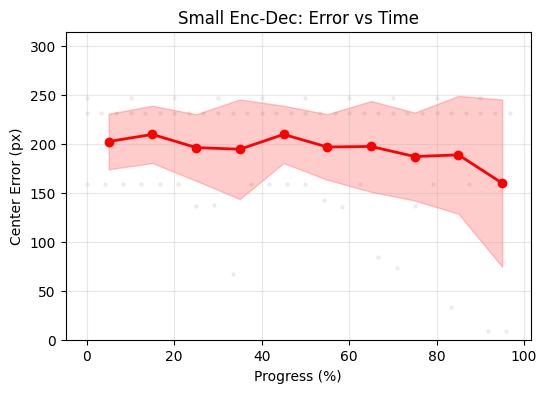

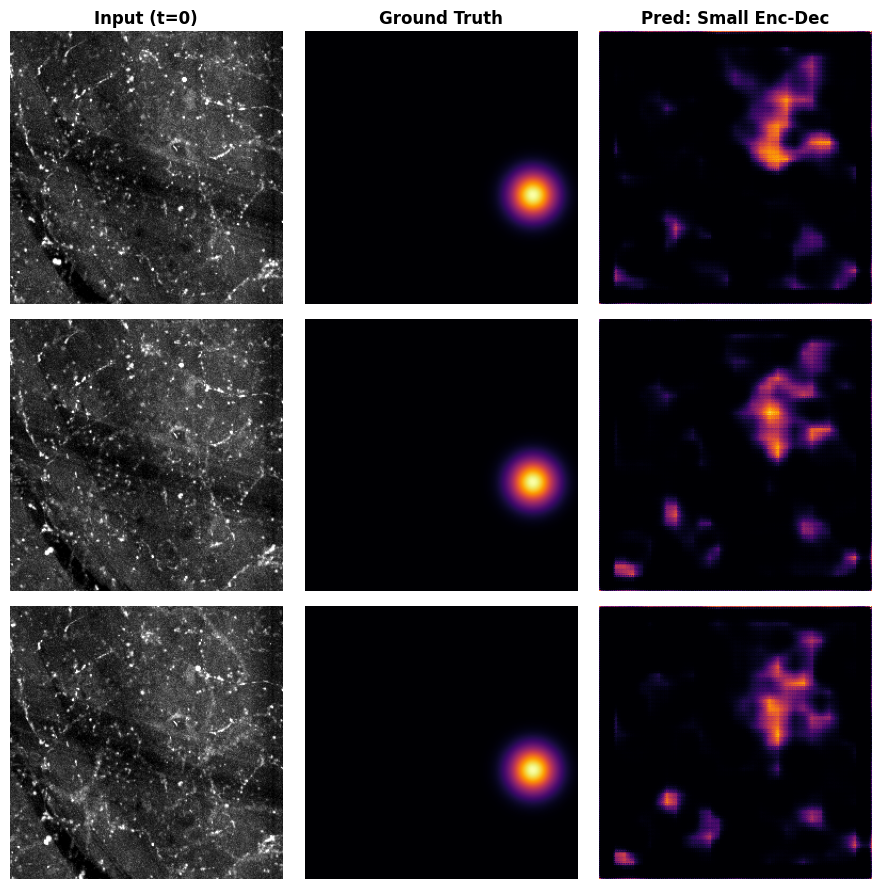


>> Visualizing: Stacked U-Net


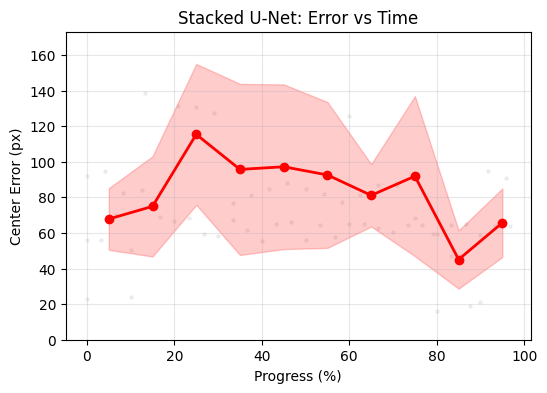

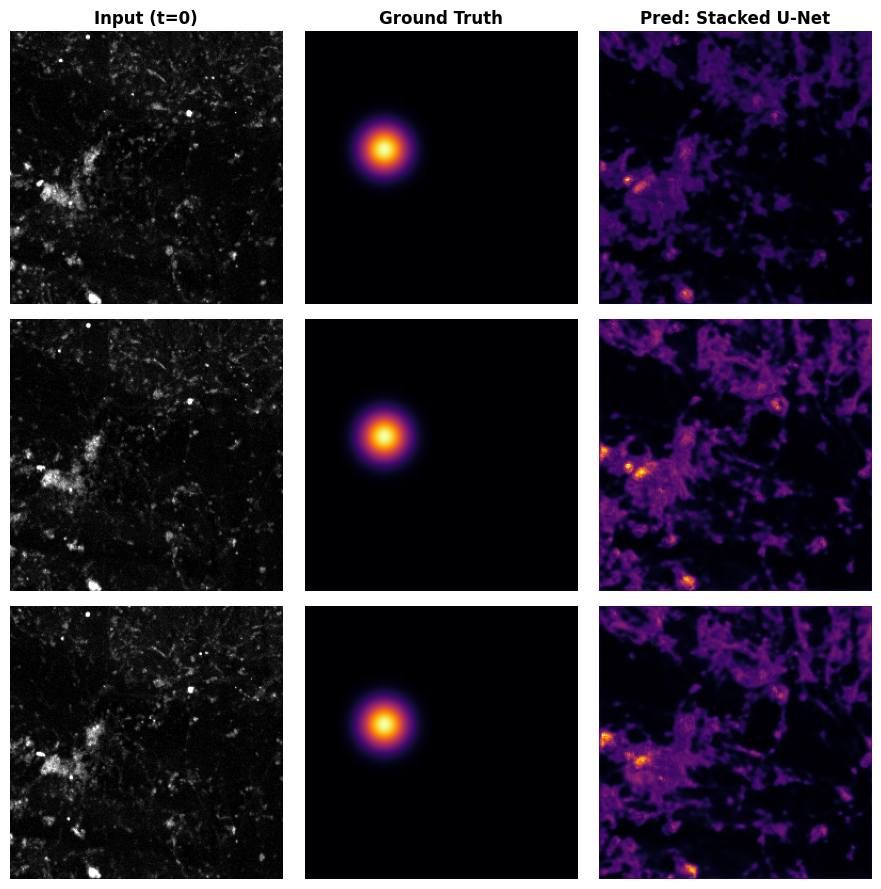


>> Visualizing: Attn 3D U-Net


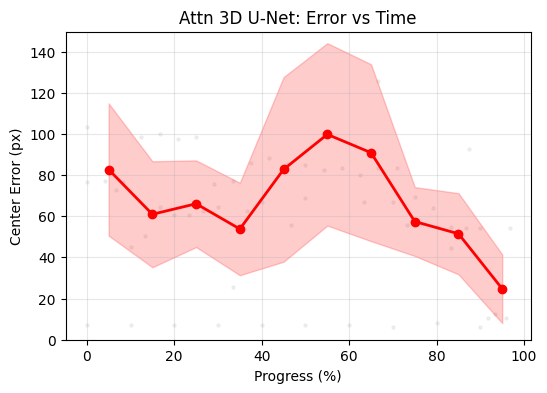

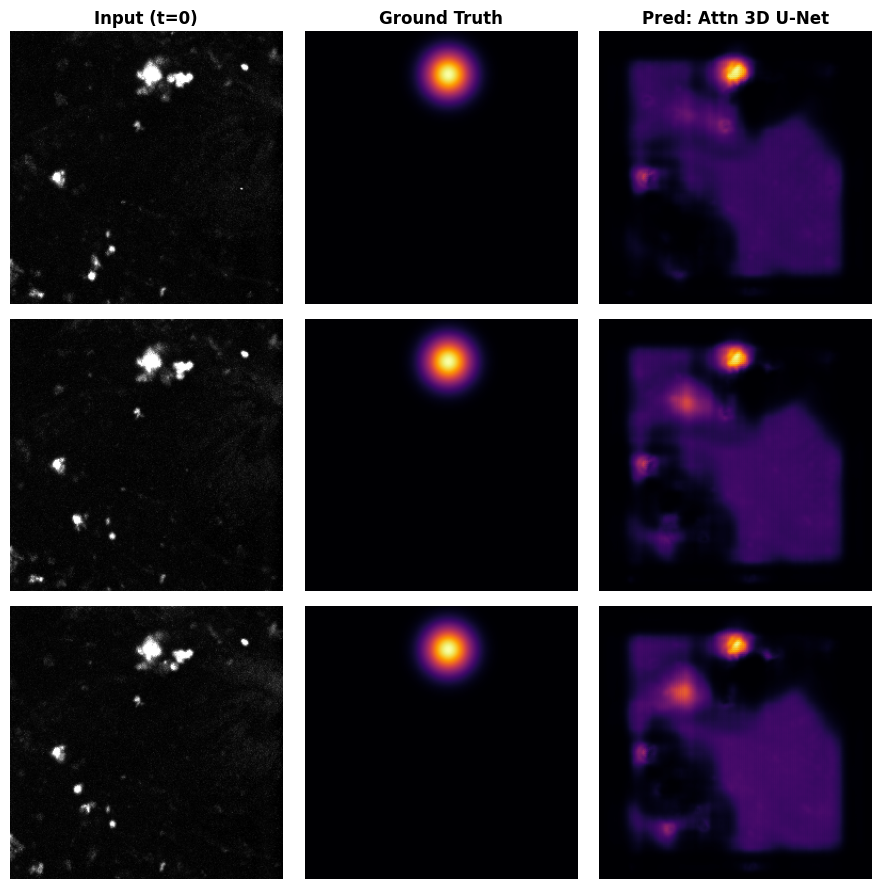

In [19]:
models_to_run = [
    (Model1_Wrapper, "Small Enc-Dec", 8),
    (Model2_Wrapper, "Stacked U-Net", 8),
    (Model3_Wrapper, "Attn 3D U-Net", 2)
]

all_results = []
N_EPOCHS = 50


for cls, name, bs in models_to_run:
    res = run_3fold_cv_accumulate(cls, name, epochs=N_EPOCHS, batch_size=bs)
    all_results.append(res)

table_data = []
for res in all_results:
    m = res['metrics_raw']
    row = {
        "Model": res['name'],
        "Center Error (px)": f"{np.mean(m['error_px']):.2f} ± {np.std(m['error_px']):.2f}",
        "Center Error (µm)": f"{np.mean(m['error_um']):.2f} ± {np.std(m['error_um']):.2f}",
        "Spatial AUROC": f"{np.mean(m['auroc']):.3f} ± {np.std(m['auroc']):.3f}",
        "Res. Robustness (Drop %)": f"{np.mean(m['robustness']):.2f} ± {np.std(m['robustness']):.2f}"
    }
    table_data.append(row)

df_final = pd.DataFrame(table_data)
print("\n" + "="*60)
print("FINAL EVALUATION METRICS (3-Fold CV Average)")
print("="*60)
display(df_final)

print("\n" + "="*60)
print("GENERATING VISUALIZATIONS")
print("="*60)

for res in all_results:
    print(f"\n>> Visualizing: {res['name']}")
    
    t_data, e_data = res['time_data']
    plot_error_vs_time(res['name'], t_data, e_data)
    
    best_model = res['model_class']().to(DEVICE)
    best_model.load_state_dict(res['best_state'])
    best_ds = DictyHeatmapDataset(data_path, res['best_folder'], N=10, sigma=8, augment=False)
    best_loader = DataLoader(best_ds, batch_size=4, shuffle=False)
    
    plot_predictions(best_model, best_loader, res['name'], DEVICE)

The overall quantitative results are summarized in the first Dataframe. Across all metrics, the 3D Attention U-Net achieves the best localization accuracy, with the lowest center error in both pixels and microns. Its spatial AUROC is also high, indicating strong discrimination between aggregation regions and background. However, this model shows a substantial drop in performance under resolution degradation, suggesting that its attention mechanisms rely heavily on high-frequency spatial details. In contrast, the Stacked U-Net provides a more balanced performance profile: its center error is moderate, and it achieves the highest spatial AUROC among all models, reflecting its ability to reliably separate foreground and background. Importantly, its robustness to resolution loss is strong, with only a mild decrease in accuracy, indicating that the refinement stage and 2.5D representation allow the model to leverage broader structural information rather than relying solely on fine-scale cues. The simple Encoder–Decoder performs the weakest across all accuracy metrics, likely due to its limited depth and lack of skip connections, but it is the most resilient to downsampling, implying that its predictions are dominated by coarse global patterns rather than fine spatial details.

To further investigate model behavior, the center error was evaluated as a function of the temporal window (measured in percentage of total frames) from which the test frames were sampled. For the simple Encoder–Decoder, the error remains relatively constant across the entire progression of aggregation, suggesting that the model does not meaningfully incorporate temporal information. The Stacked U-Net exhibits larger variability, with higher errors in early stages and a noticeable improvement toward the later phases of aggregation. This pattern aligns with the expectation that the model benefits from clearer spatial structure and more coherent motion cues present in the mid-to-late stages. The 3D Attention U-Net shows the most distinct trend. Although its error fluctuates during early and mid stages, it improves markedly as aggregation approaches completion. This behavior reflects the model's reliance on salient, well-defined regions, which become more pronounced in later frames. Together, these observations highlight the trade-off among the models: the Attention U-Net provides the highest precision when sufficient structure is present, the Stacked U-Net delivers strong and stable performance across conditions, and the Encoder–Decoder offers robustness at the cost of accuracy.